In [1]:
using Revise

In [2]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using RigidBodySim
using Flux
using JLD2
using Plots
using LCPSim
using LearningMPC
using LearningMPC.Models
using DataFrames
using Blink

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/9db0e137604e898c25f194d972715156bd46cb81-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [3]:
interval_net_param, lqrsol = jldopen("cartpole-interval-wall-params.jld2") do file
    file["net"], file["lqrsol"]
end

interval_net = jldopen("../2018-08-31-more-pendulum/cartpole-interval.jld2") do file
    file["net"]
end

Chain(Dense(4, 24, NNlib.elu), Dense(24, 24, NNlib.elu), Dense(24, 1))

In [4]:
@load "library.jld2" training

1-element Array{Symbol,1}:
 :training

In [86]:
length(training)

20982

ERROR (unhandled task failure): OutOfMemoryError()
Stacktrace:
 [1] setindex!(::ObjectIdDict, ::Any, ::Any) at ./associative.jl:430
 [2] preserve_handle at ./libuv.jl:51 [inlined]
 [3] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:40
 [4] wait(::Timer) at ./event.jl:357
 [5] (::Base.##302#303{IJulia.#send_stdout,Timer})() at ./event.jl:430


In [87]:
typeof(training)

ERROR (unhandled task failure): OutOfMemoryError()
Stacktrace:
 [1] setindex!(::ObjectIdDict, ::Any, ::Any) at ./associative.jl:430
 [2] preserve_handle at ./libuv.jl:51 [inlined]
 [3] stream_wait(::Timer, ::Condition, ::Vararg{Condition,N} where N) at ./stream.jl:40
 [4] wait(::Timer) at ./event.jl:357
 [5] (::Base.##302#303{IJulia.#send_stderr,Timer})() at ./event.jl:430


Array{Tuple{LearningMPC.Sample{5,2,Float64}},1}

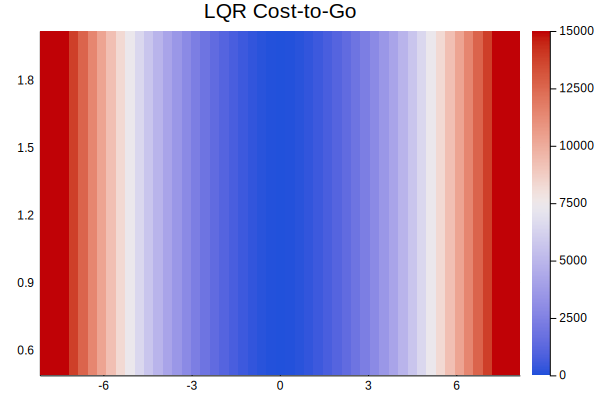

In [5]:
xx = linspace(-8, 8, 51)
yy = linspace(0.5, 2.0, 51)
getstate(x, y) = [0, 0, y, x, 0]
plt = heatmap(xx, yy, (x, y) -> (getstate(x, y) - lqrsol.x0)' * lqrsol.S * (getstate(x, y) - lqrsol.x0), 
    color=:coolwarm,
    clim=(0, 15000))
title!(plt, "LQR Cost-to-Go")
# xlabel!(plt, "Initial x velocity")
# ylabel!(plt, "Initial rotational velocity")
Plots.savefig(plt, "lqr_cost_to_go.pdf")
plt

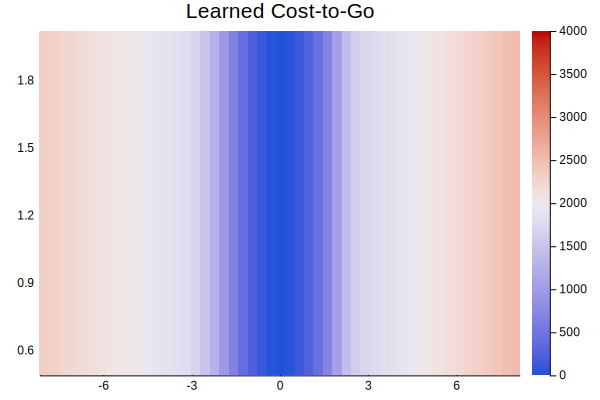

In [6]:
plt = heatmap(xx, yy, (x, y) -> Flux.Tracker.data(interval_net(getstate(x, y)[[1,2,4,5]]))[], color=:coolwarm,
    clim=(0, 4000))
title!(plt, "Learned Cost-to-Go")
# xlabel!(plt, "Initial x velocity")
# ylabel!(plt, "Initial rotational velocity")
Plots.savefig(plt, "learned_cost_to_go.pdf")
plt

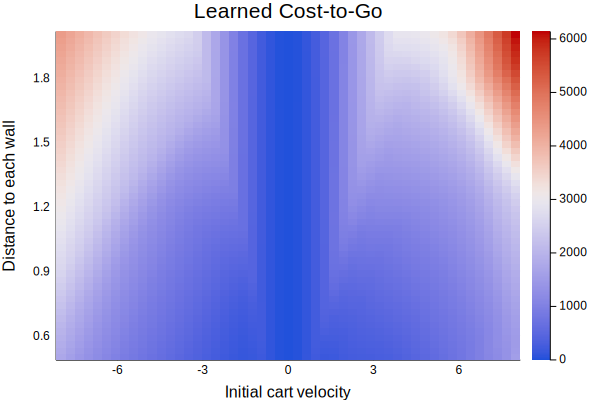

In [7]:
gr()
plt = heatmap(xx, yy, 
    (x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[], color=:coolwarm,
#     clim=(0, 6000),
)
title!(plt, "Learned Cost-to-Go")
xlabel!(plt, "Initial cart velocity")
ylabel!(plt, "Distance to each wall")
Plots.savefig(plt, "learned_cost_to_go_param.pdf")
plt

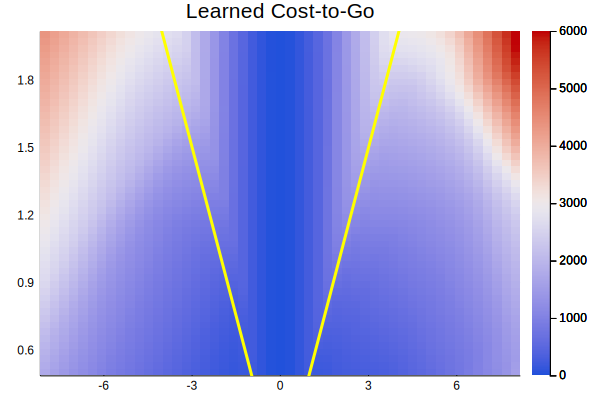

In [8]:
gr()
plt = heatmap(xx, yy, 
    (x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[], color=:coolwarm,
    clim=(0, 6000))
xl = xlims(plt)
yl = ylims(plt)
xa = linspace(0, 5)
ya = xa .* 0.5
plot!(plt, xa, ya, color=:yellow, linewidth=3, label="")
plot!(plt, .-xa, ya, color=:yellow, linewidth=3, label="")
xlims!(plt, xl)
ylims!(plt, yl)
title!(plt, "Learned Cost-to-Go")
# xlabel!(plt, "Initial x velocity")
# ylabel!(plt, "Initial rotational velocity")
Plots.savefig(plt, "learned_cost_to_go_param_annotated.pdf")
plt

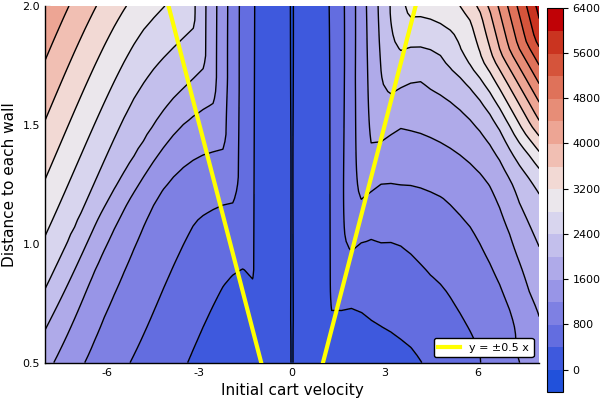

In [82]:
pyplot()
f = (x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[]
plt = Plots.contourf(xx, yy, f,
    color=:coolwarm,
    legend=:bottomright,
#     clim=(0, 6000),
#     nlevels=20,
#     levels=collect(0:500:6000),
)
Plots.contour!(plt, xx, yy, f, color=cgrad([:black, :black]))
xl = xlims(plt)
yl = ylims(plt)
xa = linspace(0, 5)
ya = xa .* 0.5
plot!(plt, xa, ya, color=:yellow, linewidth=3, label="y = ±0.5 x")
plot!(plt, .-xa, ya, color=:yellow, linewidth=3, label="")
xlims!(plt, xl)
ylims!(plt, yl)
xlabel!(plt, "Initial cart velocity")
ylabel!(plt, "Distance to each wall")
Plots.savefig(plt, "learned_cost_contour_annotated.pdf")
plt

In [14]:
using Colors

In [57]:
colorant"#fbb4ae"

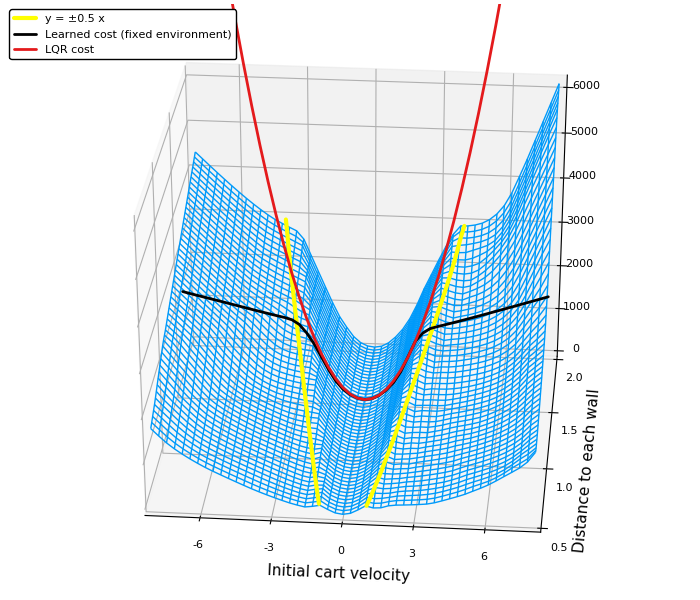

In [85]:
pyplot()
plt = wireframe(xx, yy, 
    (x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[], 
#     color=:coolwarm,
#     color=colorant"#b3cde3",
#     clim=(0, 4000),
#     alpha=0.9,
    size=(700, 600),
    camera=(5, 30),
    label="Learned cost (parametric environment)",
    legend=:topleft,
#     background_color=RGBA(1, 1, 1, 0),
)
xl = xlims(plt)
yl = ylims(plt)
zl = zlims(plt)

xa = linspace(1, 4)
ya = xa .* 0.5
za = ((x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[]).(xa, ya) .+ 1
plot!(plt, xa, ya, za, color=:yellow, linewidth=3, label="y = ±0.5 x")
plot!(plt, .-xa, ya, za, color=:yellow, linewidth=3, label="")

f = (x) -> Flux.Tracker.data(interval_net([0, 0, x, 0]))[]
plot!(plt, xx, fill(1.5, length(xx)), f.(xx), linewidth=2, color=:black, label="Learned cost (fixed environment)")

f = (x) -> ([0, 0, 1.5, x, 0] - lqrsol.x0)' * lqrsol.S * ([0, 0, 1.5, x, 0] - lqrsol.x0)
plot!(plt, xx, fill(1.5, length(xx)), f.(xx), linewidth=2, color=colorant"#e41a1c", label="LQR cost")


xlims!(plt, xl)
ylims!(plt, yl)
zlims!(plt, zl)
xlabel!(plt, "Initial cart velocity")
ylabel!(plt, "Distance to each wall")
Plots.savefig(plt, "learned_param_cost_3d.pdf")
plt

In [11]:
plt = surface(xx, yy, 
    (x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[], color=:coolwarm,
    clim=(0, 4000),
#     alpha=0.9
)
xl = xlims(plt)
yl = ylims(plt)
xa = linspace(0, 5)
ya = xa .* 0.5
za = ((x, y) -> Flux.Tracker.data(interval_net_param(getstate(x, y)))[]).(xa, ya)
plot!(plt, xa, ya, za, color=:yellow, linewidth=5, label="")
plot!(plt, .-xa, ya, za, color=:yellow, linewidth=5, label="")
xlims!(plt, xl)
ylims!(plt, yl)
plt

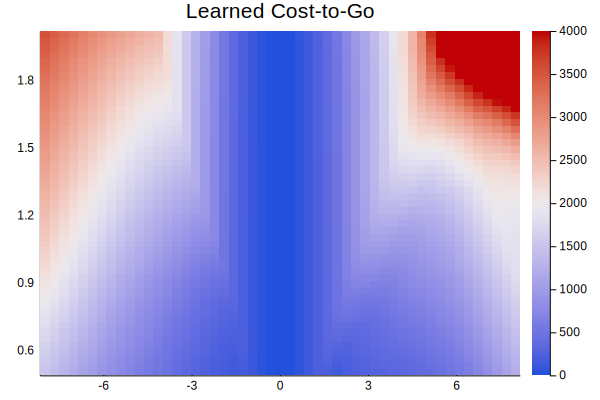

In [12]:
gr()
plt = heatmap(xx, yy, 
    (x, y) -> Flux.Tracker.data(interval_net_param([0, 0, y, 0, x]))[], color=:coolwarm,
    clim=(0, 4000))
title!(plt, "Learned Cost-to-Go")